In [1]:
from rdflib import Graph, Namespace, URIRef, RDF, RDFS, OWL

# Namespaces
NELL = Namespace("http://nell-995.org/")
g = Graph()
g.bind("nell", NELL)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)

# Define a generic entity class
g.add((NELL.Entity, RDF.type, OWL.Class))

# Helper function for URI cleaning
def clean_uri(text):
    return text.replace("concept:", "").replace(":", "_").replace("/", "_")

path = "kb_env_rl.txt"
i=0
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            subject, obj, relation = parts  # predicate = 3rd column
            s = URIRef(f"{NELL}{clean_uri(subject)}")
            p = URIRef(f"{NELL}{clean_uri(relation)}")
            o = URIRef(f"{NELL}{clean_uri(obj)}")

            # Add the triple itself
            g.add((s, p, o))

            # Add class and property semantics
            g.add((p, RDF.type, OWL.ObjectProperty))
            g.add((s, RDF.type, NELL.Entity))
            g.add((o, RDF.type, NELL.Entity))
            i+=1

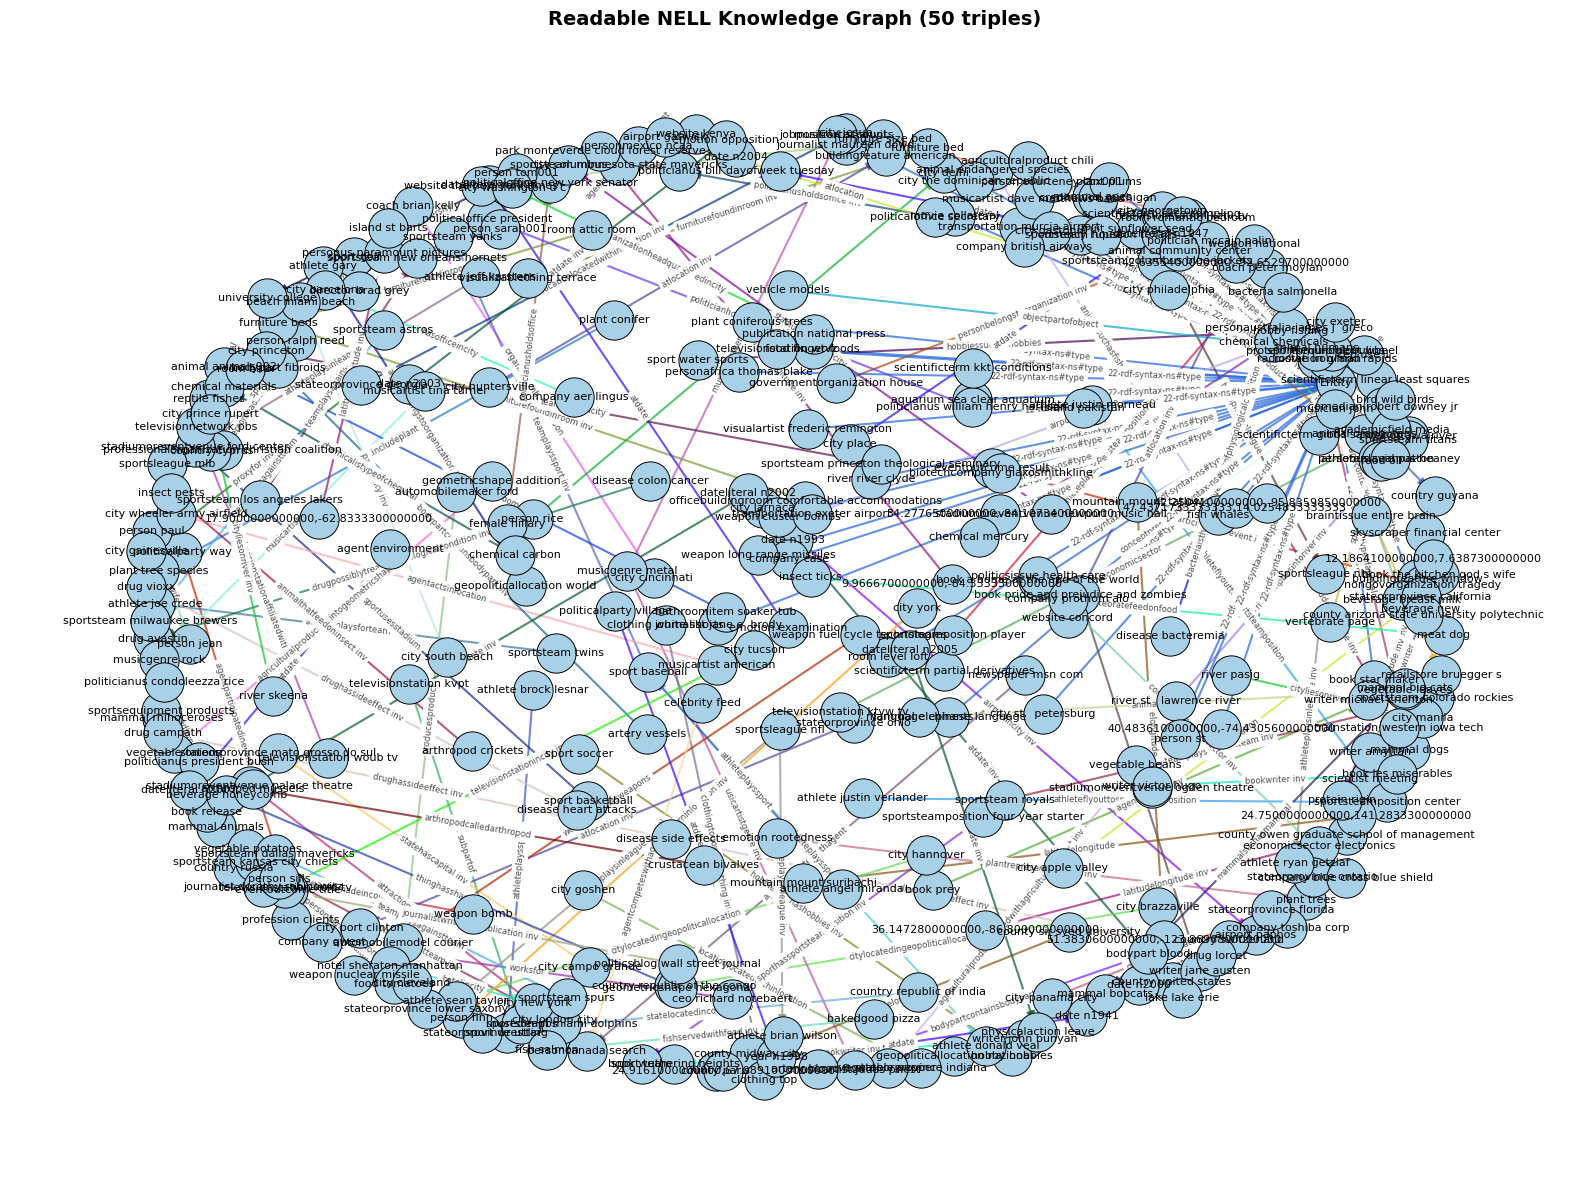

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Function to clean up labels for readability
def short_label(uri):
    label = uri.split("/")[-1]  # get last part of the URI
    label = label.replace("concept_", "").replace("_", " ")
    return label

# Sample a small portion for clarity
subgraph = list(g)[:200]
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))

# Position nodes with a force-directed layout
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42)

# Prepare label maps
node_labels = {n: short_label(n) for n in G.nodes()}
edge_labels = {(s, o): short_label(p) for s, o, p in G.edges(data='label')}

# Assign colors by relation type
relations = list(set(edge_labels.values()))
color_map = {r: (random.random(), random.random(), random.random()) for r in relations}
edge_colors = [color_map[edge_labels[(u, v)]] for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#a8d0e6", edgecolors="black", linewidths=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowsize=12, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5, alpha=0.7)

plt.title("Readable NELL Knowledge Graph (50 triples)", fontsize=14, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
!pip install transformers

In [11]:
import re
from flair.data import Sentence
from flair.models import SequenceTagger
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# -----------------------------------------------------------------------------
# Load Models
# -----------------------------------------------------------------------------
ner_tagger = SequenceTagger.load("ner-large")
tokenizer_rebel = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model_rebel = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

# -----------------------------------------------------------------------------
# Cleaning
# -----------------------------------------------------------------------------
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s,.!?-]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# -----------------------------------------------------------------------------
# Flair NER
# -----------------------------------------------------------------------------
def extract_entities(text):
    sentence = Sentence(text)
    ner_tagger.predict(sentence)
    return [
        {"text": ent.text, "type": ent.get_label('ner').value}
        for ent in sentence.get_spans("ner")
    ]

# -----------------------------------------------------------------------------
# Parser for your REBEL output:
# "Cristiano Ronaldo  Al Nassr  member of sports team"
# -----------------------------------------------------------------------------
def parse_rebel_output(text):
    # Split by 2+ spaces → because names contain spaces
    parts = re.split(r"\s{2,}", text.strip())

    if len(parts) == 3:
        return [{
            "subject": parts[0].strip(),
            "relation": parts[2].strip(),
            "object": parts[1].strip(),
            "subject_id": None,
            "object_id": None
        }]
    else:
        return []

# -----------------------------------------------------------------------------
# REBEL wrapper
# -----------------------------------------------------------------------------
def extract_rebel_relations(text):
    inputs = tokenizer_rebel(text, return_tensors="pt", truncation=True)
    outputs = model_rebel.generate(
        **inputs,
        max_length=256,
        num_beams=3,
        length_penalty=1.0
    )

    decoded = tokenizer_rebel.decode(outputs[0], skip_special_tokens=True)

    print("\n===== RAW REBEL OUTPUT =====")
    print(decoded)
    print("============================\n")

    return parse_rebel_output(decoded)

# -----------------------------------------------------------------------------
# Combined pipeline
# -----------------------------------------------------------------------------
def getnlp(text):
    cleaned = clean_text(text)

    return {
        "clean_text": cleaned.lower(),
        "entities": extract_entities(cleaned),
        "relations": extract_rebel_relations(cleaned)
    }

# -----------------------------------------------------------------------------
# Example
# -----------------------------------------------------------------------------
article = """
Cristiano Ronaldo scored 2 goals for Al Nassr yesterday in Riyadh.
He is considered one of the best players in the world.
"""

result = getnlp(article)

print("\n==== ENTITIES ====")
print(result["entities"])

print("\n==== RELATIONS ====")
print(result["relations"])


2025-11-15 14:34:36,083 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>

===== RAW REBEL OUTPUT =====
 Cristiano Ronaldo  Al Nassr  member of sports team


==== ENTITIES ====
[{'text': 'Cristiano Ronaldo', 'type': 'PER'}, {'text': 'Al Nassr', 'type': 'ORG'}, {'text': 'Riyadh', 'type': 'LOC'}]

==== RELATIONS ====
[{'subject': 'Cristiano Ronaldo', 'relation': 'member of sports team', 'object': 'Al Nassr', 'subject_id': None, 'object_id': None}]


Cristiano Ronaldo → http://nell-995.org/concept_athlete_cristiano_ronaldo
2 → None
Al Nassr → http://nell-995.org/concept_organization_al_eastern_division
yesterday → None
Riyadh → http://nell-995.org/concept_city_riyadh
one → None
